**Capstone Project Group A CV1**

## Pneumonia Detection Challenge
The goal is to build a pneumonia detection system, to locate the position of inflammation in an image.

This model is built using Detectron2 (Faster_RCNN) on pytorch: https://github.com/facebookresearch/detectron2


**Data preprocessing steps needed are as below:**
1. Convert all the dicom images to jpg as Detectron2 can't directly read dicom images  : *convert_to_jpg()*
2. Image augmentation using albumentations library
3. Convert the data to coco json format : *get_data_dicts()*

In [1]:
!pip install pyyaml==5.1
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
!pip install pydicom
!pip install sklearn
!pip install funcy
!pip install argparse

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [2]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

1.9.0+cu111 True


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import glob, os, json, cv2, random
from google.colab.patches import cv2_imshow
import pydicom as pyd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import matplotlib.pyplot as plt

In [4]:
base_dir='/content/drive/MyDrive/colab'
data_dir = base_dir+'/input'
working_dir = base_dir+'/working'

train_labels_df = pd.read_csv(data_dir+'/stage_2_train_labels.csv')
label_meta_data = pd.read_csv(data_dir+'/stage_2_detailed_class_info.csv')

train_dicom_dir = os.path.join(data_dir, 'stage_2_train_images')
test_dicom_dir = os.path.join(data_dir, 'stage_2_test_images')

train_labels_df.tail(10)

patientId      x  ...  height  Target
30217  c1e228e4-b7b4-432b-a735-36c48fdb806f    NaN  ...     NaN       0
30218  c1e3eb82-c55a-471f-a57f-fe1a823469da    NaN  ...     NaN       0
30219  c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2  666.0  ...   223.0       1
30220  c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2  316.0  ...   273.0       1
30221  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  609.0  ...   284.0       1
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  185.0  ...   379.0       1
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba    NaN  ...     NaN       0
30224  c1f6b555-2eb1-4231-98f6-50a963976431    NaN  ...     NaN       0
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  ...   345.0       1
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  ...   356.0       1

[10 rows x 6 columns]

In [5]:
def get_files(dicom_dir):
    files = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(files))

def parse_dataset(dicom_dir, anns): 
    image_files = get_files(dicom_dir)
    image_annotations = {fp: [] for fp in image_files}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
        if index == 0:
          print(row)
    return image_files, image_annotations 

image_files, image_annotations = parse_dataset(train_dicom_dir, anns=train_labels_df)

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


In [6]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==1.1.0 is successfully installed


In [7]:
import albumentations as A
from  albumentations.core.composition import BboxParams
transform = A.Compose([
              A.RandomCrop(width=1024, height=1024),
              A.HorizontalFlip(p=0.5),
              A.RandomBrightnessContrast(p=0.2),
          ],  bbox_params=BboxParams(format='coco', min_area=1024, min_visibility=0.1)
)

In [8]:
def convert_to_jpg(input_file, output_file):
    ds = pyd.dcmread(input_file)
    cv2.imwrite(output_file, ds.pixel_array)

# for d in ["test"]:
#     input_path = os.path.join(data_dir, "stage_2_"+d+"_images")
   
#     for file in get_files(input_path):
#          output_file = os.path.join(data_dir, d, os.path.basename(file).replace(".dcm", "")+".jpg")
#          convert_to_jpg(file, output_file)

In [9]:
def show(d):  
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=pnuemonia_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [10]:
from detectron2.structures import BoxMode
  
def get_data_dicts(img_dir, augment):
    dataset_dicts = []
    for idx, arr in enumerate(image_annotations.values()):
        record = {}
        filename = os.path.join(img_dir, arr[0]["patientId"]+".jpg")
        
        img = cv2.imread(filename)
        if img is None:
          continue;
        height, width = img.shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        objs = []
        aug_boxes = []
        for v in arr: 
          if np.isnan(float(v["x"])):
            continue
          obj = {
                  "bbox": [v["x"], v["y"], v["width"], v["height"]],
                  "bbox_mode": BoxMode.XYWH_ABS,
                  "category_id": 0,
              }
          aug_boxes.append([v["x"], v["y"], v["width"], v["height"], 'pnuemonia']) 
          objs.append(obj)
        record["annotations"] = objs
        # dataset_dicts.append(record)
        
        rndm = random.randint(1, 10)
        if augment and rndm < 3 and len(objs) > 0:
            transformed = transform(image=img, bboxes=aug_boxes)
            transformed_image = transformed['image']
            transformed_bboxes = transformed['bboxes']
            aug_file_name = os.path.join(img_dir,'augment', arr[0]["patientId"]+".jpg")
            cv2.imwrite(aug_file_name, transformed_image)
            # plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
            aug_objs = []
            for row in transformed_bboxes: 
              obj = {
                  "bbox": row[0:4],
                  "bbox_mode": BoxMode.XYWH_ABS,
                  "category_id": 0,
              }
              aug_objs.append(obj)

            record_aug = {}    
            record_aug["image_id"] = idx
            record_aug["height"] = height
            record_aug["width"] = width
            record_aug["annotations"] = aug_objs
            record_aug["file_name"] = aug_file_name
            record_aug["image_id"] = idx+40000
           
            show(record)
            show(record_aug)
            print(filename)
            print(aug_file_name)
            break;

    return dataset_dicts

Metadata(name='train')


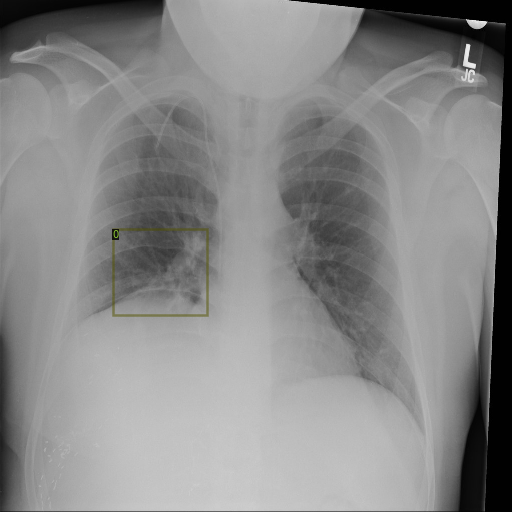

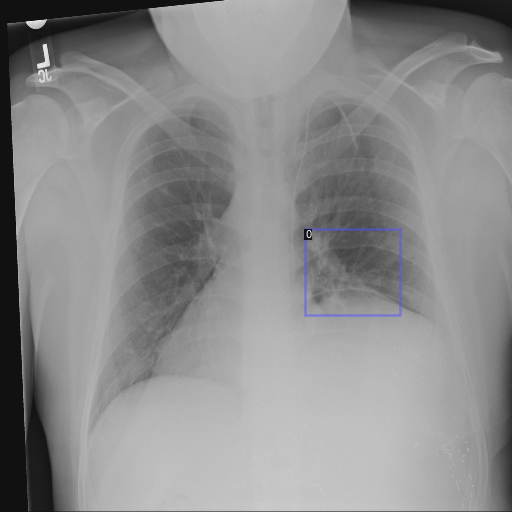

/content/drive/MyDrive/colab/input/train/382db3e8-f756-48c5-8def-e0630634a680.jpg
/content/drive/MyDrive/colab/input/train/augment/382db3e8-f756-48c5-8def-e0630634a680.jpg


[]

In [12]:
pnuemonia_metadata = MetadataCatalog.get("train")
print( MetadataCatalog.get("train"))
get_data_dicts(data_dir+'/train', True)

## Create dataset without image augmentation

In [13]:
# import json
# out_file = open(os.path.join(data_dir,"coco-full.json"), "w")
# json.dump(get_data_dicts(data_dir+'/train', False), out_file, indent = 4) 
# out_file.close()

## Split the dataset into train and validation

In [73]:
with open(os.path.join(data_dir,"coco-full.json"), 'r') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)
 
X_train, X_val = train_test_split(obj, test_size=0.1)
print(len(X_train))
print(len(X_val))

24015
2669


In [15]:
def get_dicts(name):
    return X_train if name == 'train' else X_val

for d in ["train", "val"]:
    try:
      DatasetCatalog.register(d, lambda d=d: get_dicts(d))
      MetadataCatalog.get(d).set(thing_classes=["pneumonia"])
    except:
      print('')

In [24]:
from detectron2.engine import DefaultTrainer
global cfg 
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("train")
cfg.DATASETS.TEST = ()
cfg.OUTPUT_DIR = ( base_dir + "/output")
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025 
cfg.SOLVER.MAX_ITER = 500    
cfg.SOLVER.STEPS = []     
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  

def train_model(): 
  os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
  trainer = DefaultTrainer(cfg) 
  trainer.resume_or_load(resume=False)
  trainer.train()

def evaluate(cnt):
  # Inference should use the config with parameters that are used in training
  # cfg now already contains everything we've set previously. We changed it a little bit for inference:
  cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
  
  result = [];
  ctr = 0;
  for d in X_val:      
      im = cv2.imread(d["file_name"])
      outputs = predictor(im) 
      no_objects = len(outputs["instances"].pred_boxes)

      predicted = 1 if no_objects > 0 else 0
      ground_truth = 1 if len(d["annotations"]) > 0 else 0
      result.append({"id":  os.path.basename(d["file_name"]).replace(".jpg", ""), "ground_truth": ground_truth, "predicted": predicted})
      ctr +=1
      if ctr > cnt:
        break;
  return result

In [74]:
train_model()

[10/31 12:34:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

## Inference & evaluation using the trained model

In [75]:
result = evaluate(3000)

In [76]:
df = pd.DataFrame(result)
df.head(10)

id  ground_truth  predicted
0  541fd23b-53f2-4bfc-abe6-92f330f2474e             0          1
1  9dcc29e1-433e-426a-8d6e-6243ec981883             0          0
2  1c44e0a4-4612-438f-9a83-8d5bf919cb67             1          1
3  076eab63-d75d-4272-a5d3-13eae02f2c8f             1          1
4  d6ccb839-1988-4113-8233-c7698065a8a1             0          1
5  83126b29-c67f-4296-bf41-882b297c7cac             0          1
6  d877d8be-7d38-43aa-b359-bd86cf3951c3             1          1
7  febbc3ae-c1c8-4625-8cf0-3170c460ca4f             0          1
8  9d982975-b6f9-45ef-893f-4a3e633f9f3b             0          1
9  7d351015-e0a1-4ba9-a310-1b1f8dc72256             0          0

In [77]:
print(classification_report(df['ground_truth'], df['predicted']))
accuracy = accuracy_score(df['ground_truth'], df['predicted'])
print('Model accuracy is: ', accuracy)

              precision    recall  f1-score   support

           0       0.91      0.55      0.68      2047
           1       0.36      0.83      0.50       622

    accuracy                           0.61      2669
   macro avg       0.64      0.69      0.59      2669
weighted avg       0.79      0.61      0.64      2669

Model accuracy is:  0.6129636568002997


### Create dataset with image augmentation for positive cases and save

In [29]:
# import json
# out_file = open(os.path.join(data_dir,"coco-full-aug.json"), "w")
# json.dump(get_data_dicts(data_dir+'/train', True), out_file, indent = 4) 
# out_file.close()

### Split the dataset into train and validation

In [30]:
with open(os.path.join(data_dir,"coco-full-aug.json"), 'r') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)
 
X_train, X_val = train_test_split(obj, test_size=0.1)
print(len(X_train))
print(len(X_val))

25604
2845


In [31]:
train_model()

[10/31 11:49:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

## Inference & evaluation using the trained model on augmented data

In [69]:
result = evaluate(3000)

In [70]:
df_aug = pd.DataFrame(result)
df_aug.head()

id  ground_truth  predicted
0  8f54d530-066c-4a62-8d66-10293a8fe7d9             0          0
1  b1572976-1a77-4ed8-a2cd-4c3ee33ff27d             0          0
2  3b81bcea-ee88-4c13-b4f6-2a53161d2b22             0          0
3  f9a571b8-65a5-463c-8ee7-db2f3728f5d2             1          1
4  f2f6d2de-0a65-46f8-8353-3e0304a98732             0          1

In [71]:
print(classification_report(df_aug['ground_truth'], df_aug['predicted']))
accuracy = accuracy_score(df_aug['ground_truth'], df_aug['predicted'])
print('Model accuracy is: ', accuracy)

              precision    recall  f1-score   support

           0       0.86      0.64      0.73      2068
           1       0.43      0.72      0.54       777

    accuracy                           0.66      2845
   macro avg       0.65      0.68      0.64      2845
weighted avg       0.74      0.66      0.68      2845

Model accuracy is:  0.6636203866432338


### Make Predictions on Random Data

In [59]:

def get_test_files(dir):
    files = glob.glob(dir+'/'+'*.jpg')
    return list(set(files))



Prediction


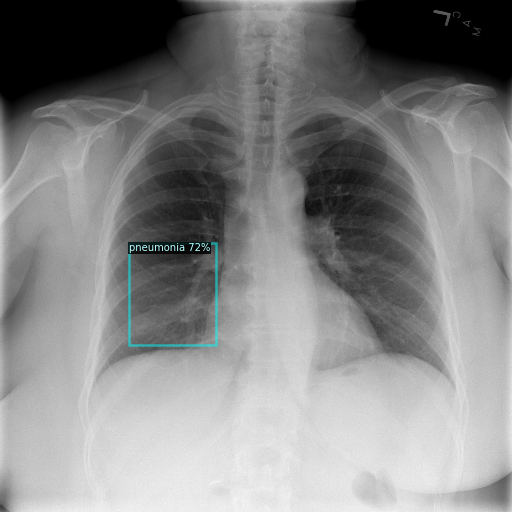


Ground Truth


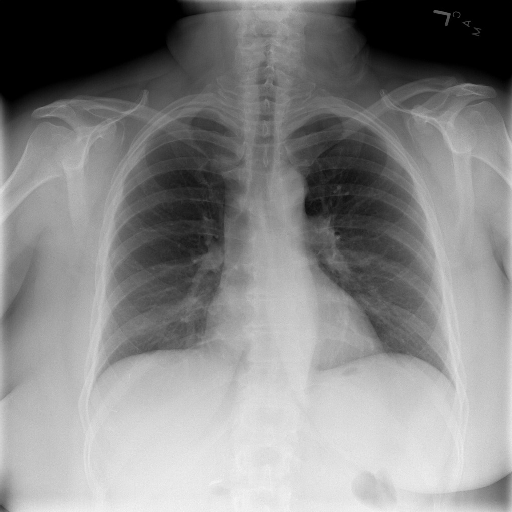


Prediction


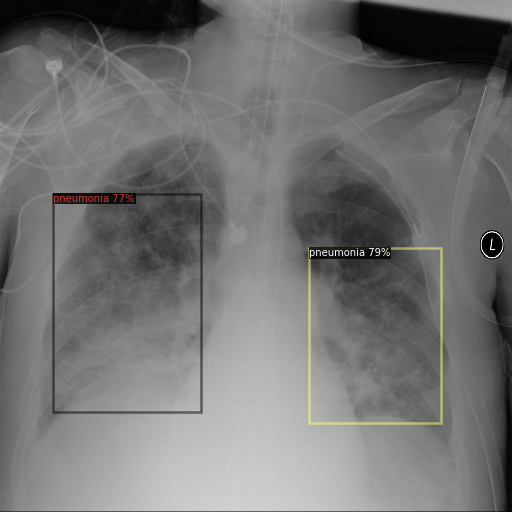


Ground Truth


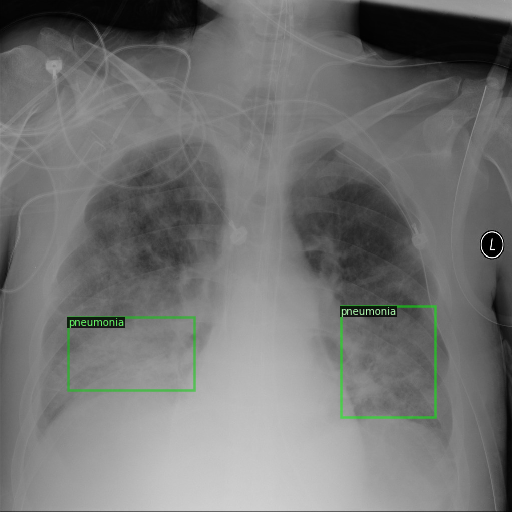


Prediction


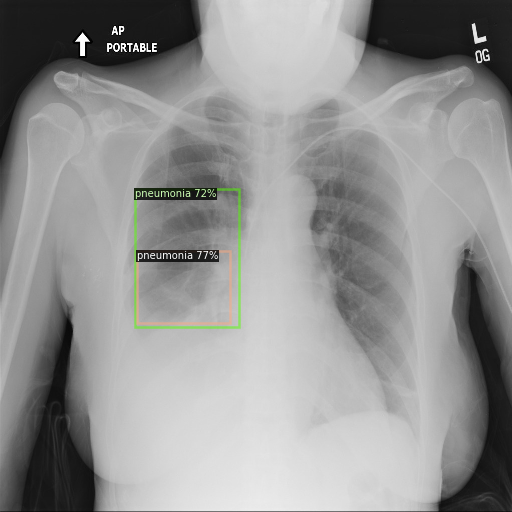


Ground Truth


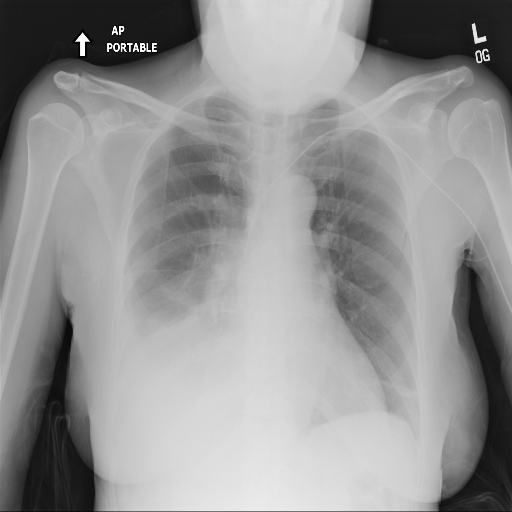


Prediction


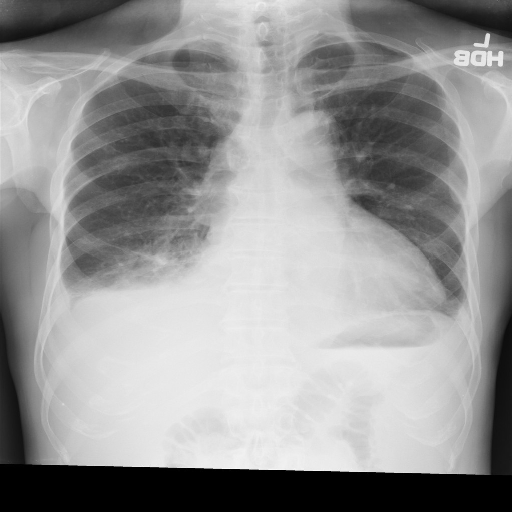


Ground Truth


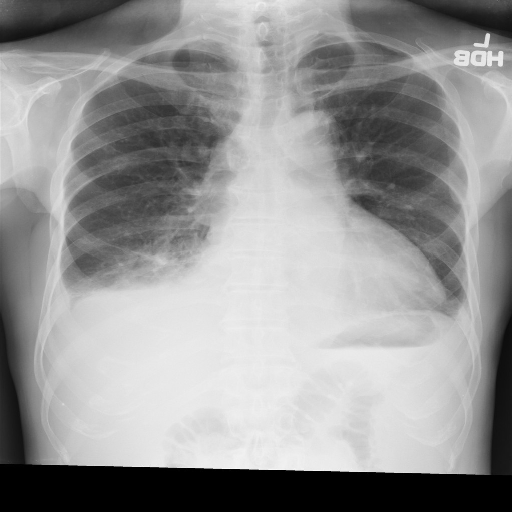


Prediction


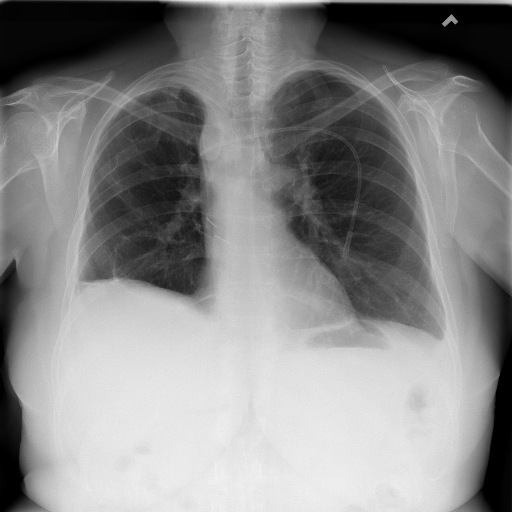


Ground Truth


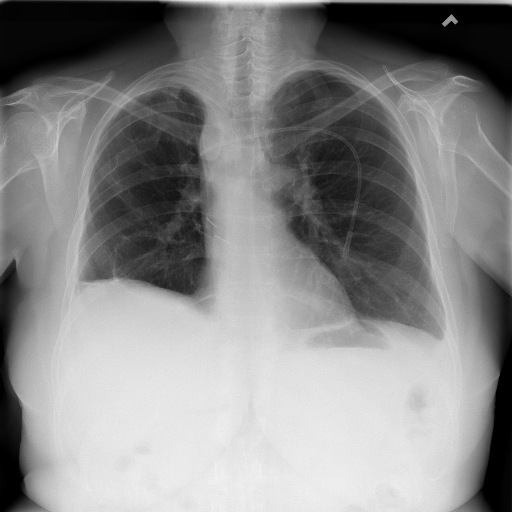


Prediction


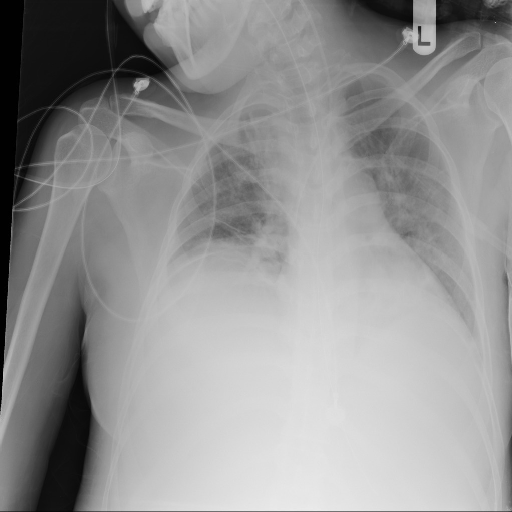


Ground Truth


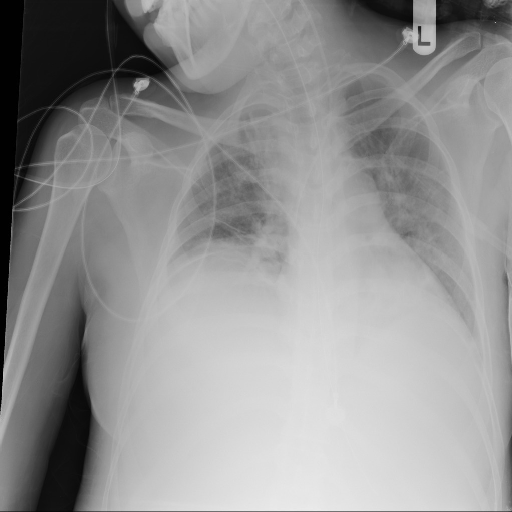


Prediction


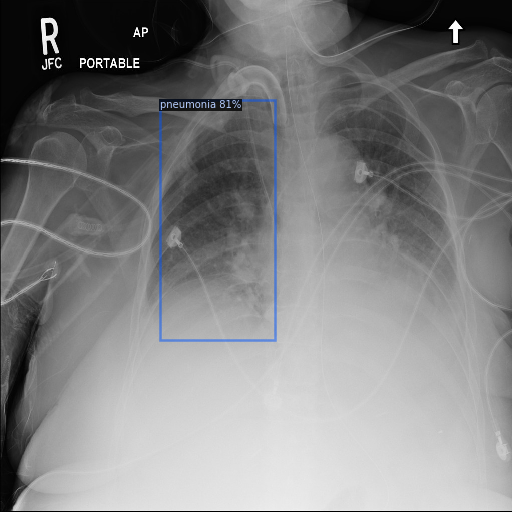


Ground Truth


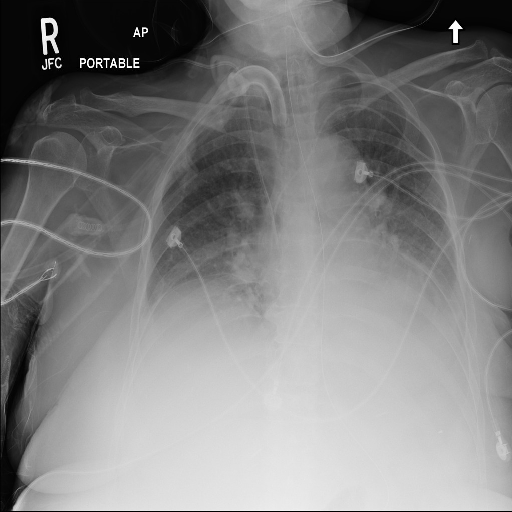


Prediction


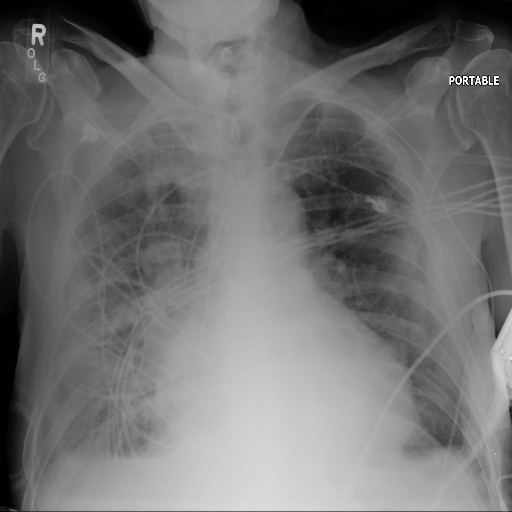


Ground Truth


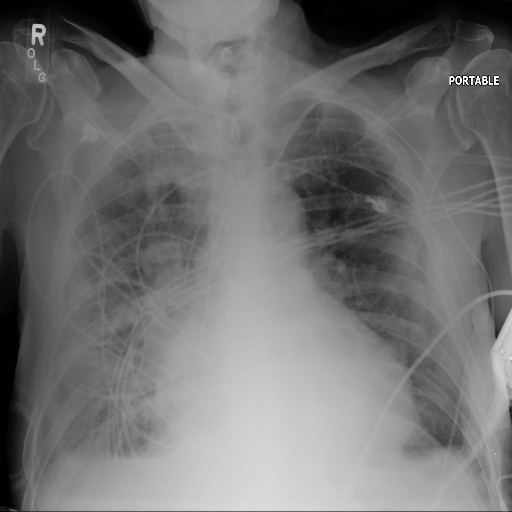


Prediction


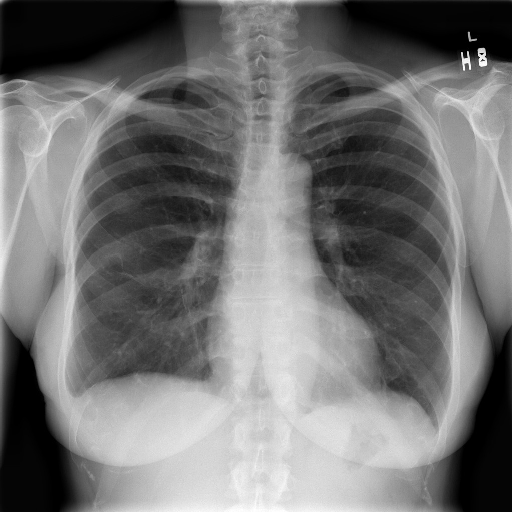


Ground Truth


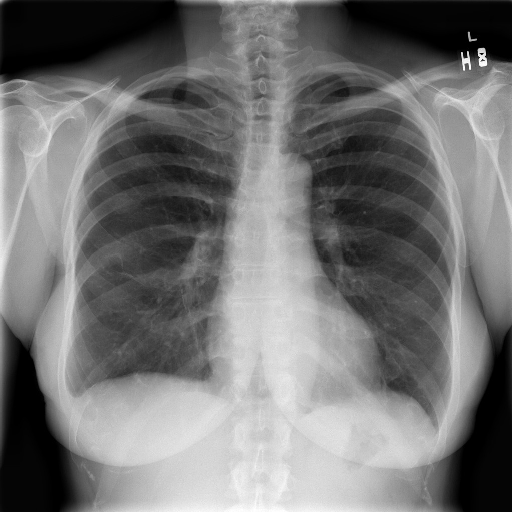


Prediction


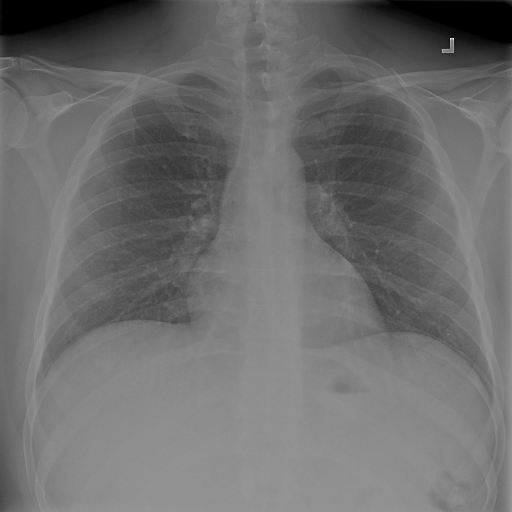


Ground Truth


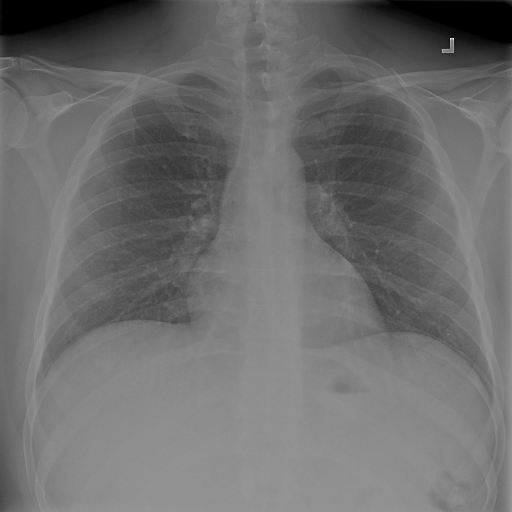

In [68]:
from detectron2.utils.visualizer import ColorMode
# get_test_files(data_dir+'/test')
for d in random.sample(X_val, 10):      
    im = cv2.imread(d['file_name'])
    predictor = DefaultPredictor(cfg)
    outputs = predictor(im)  
    v = Visualizer(im[:, :, ::-1],
                   metadata=pnuemonia_metadata, 
                   scale=0.5, 
                  #  instance_mode=ColorMode.IMAGE_BW   
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu")) 
    
    print("\nPrediction")
    cv2_imshow(out.get_image()[:, :, ::-1])

    print("\nGround Truth")
    show(d)
    

